In [101]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
# Pull in remote dataset from UCI ML repo
raw_data = fetch_ucirepo(id=849)

In [30]:
# Create flat table
raw_df: pd.DataFrame = raw_data.data.features.merge(raw_data.data.targets,
                                                    how='outer',
                                                    left_index=True,
                                                    right_index=True)

# Relabeling with friendly column headers
new_colnames = ["datetime",
                "temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows",
                "zone_1_power",
                "zone_2_power",
                "zone_3_power"]

colname_updates = {orig_colnames: new_colnames for orig_colnames,
                   new_colnames in zip(raw_df.columns, new_colnames)}

tetoun_power: pd.DataFrame = raw_df.rename(columns=colname_updates)

# Feature Engineering
tetoun_power["datetime"] = pd.to_datetime(tetoun_power["datetime"])

tetoun_power["total_power"] = tetoun_power["zone_1_power"] + \
    tetoun_power["zone_2_power"] + tetoun_power["zone_3_power"]

tetoun_power = tetoun_power.assign(
    year=tetoun_power["datetime"].dt.year,
    month=tetoun_power["datetime"].dt.month,
    day=tetoun_power["datetime"].dt.day,
    hour=tetoun_power["datetime"].dt.hour,
    minute=tetoun_power["datetime"].dt.minute,
    day_of_week=tetoun_power["datetime"].dt.dayofweek,
    day_of_year=tetoun_power["datetime"].dt.dayofyear,
    weekofyear=tetoun_power["datetime"].dt.isocalendar().week,
    zone_1_2wma=tetoun_power["zone_1_power"].rolling(window=72).mean(),
    zone_1_1mma=tetoun_power["zone_1_power"].rolling(window=144).mean(),
    zone_1_2mma=tetoun_power["zone_1_power"].rolling(window=288).mean(),
    zone_1_3mma=tetoun_power["zone_1_power"].rolling(window=432).mean(),
    zone_1_6mma=tetoun_power["zone_1_power"].rolling(window=864).mean(),
    zone_2_6mma=tetoun_power["zone_2_power"].rolling(window=864).mean(),
    zone_3_6mma=tetoun_power["zone_3_power"].rolling(window=864).mean(),
    total_power_6mma=tetoun_power["total_power"].rolling(window=864).mean()
)



In [5]:
tetoun_power.head()

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power,zone_2_power,zone_3_power,year,month,day,hour,minute,day_of_week,day_of_year,weekofyear,total_power
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,1,1,0,0,6,1,52,70425.53544
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,1,1,0,10,6,1,52,69320.84387
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,1,1,0,20,6,1,52,67803.22193
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,1,1,0,30,6,1,52,65489.23209
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,1,1,0,40,6,1,52,63650.44627


In [13]:
tetoun_power.loc[tetoun_power["month"] == 1].shape[0]/31/2

72.0

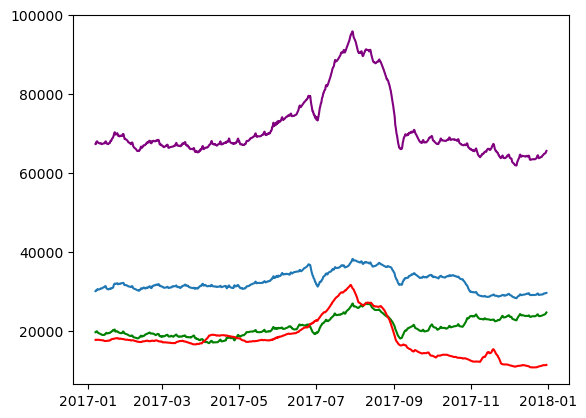

In [31]:
fig, ax = plt.subplots()

ax.plot(tetoun_power["datetime"], tetoun_power["zone_1_6mma"])
ax.plot(tetoun_power["datetime"], tetoun_power["zone_2_6mma"], color="green")
ax.plot(tetoun_power["datetime"], tetoun_power["zone_3_6mma"], color="red")
ax.plot(tetoun_power["datetime"], tetoun_power["total_power_6mma"], color="purple")

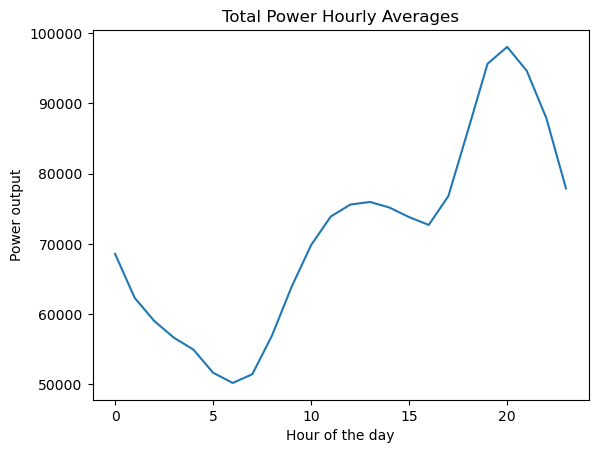

In [80]:
tp_hourly_avg = tetoun_power.groupby("hour").agg({"total_power": "mean"})

fig, ax = plt.subplots()

ax.plot(np.arange(0, 24, 1), tp_hourly_avg["total_power"])
ax.set_title("Total Power Hourly Averages")
ax.set_ylabel("Power output")
ax.set_xlabel("Hour of the day")
plt.show()

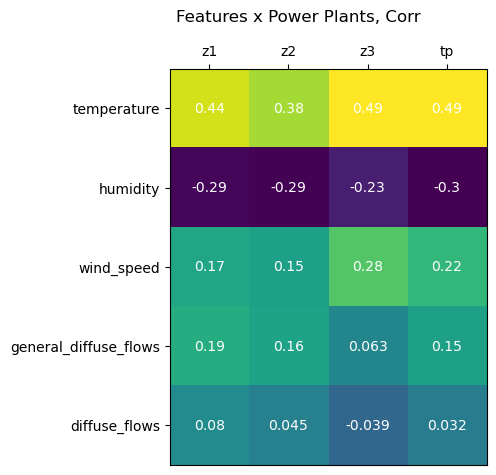

In [77]:
common_feats = ["temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows"]

tp_corr = tetoun_power[common_feats+["total_power"]] \
    .corr().loc[pd.Index(common_feats), "total_power"]

z1_corr = tetoun_power[common_feats+["zone_1_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_1_power"]

z2_corr = tetoun_power[common_feats+["zone_2_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_2_power"]

z3_corr = tetoun_power[common_feats+["zone_3_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_3_power"]

corr_df = pd.DataFrame({"z1": z1_corr, "z2": z2_corr,
                       "z3": z3_corr, "tp": tp_corr})

fig, ax = plt.subplots()

ax.imshow(corr_df)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(corr_df.shape[1]), labels=corr_df.columns)
ax.set_yticks(np.arange(corr_df.shape[0]), labels=common_feats)

# Loop over data dimensions and create text annotations.
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        text = ax.text(j, i, f"{corr_df.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.suptitle("Features x Power Plants, Corr")   
plt.tight_layout()     
plt.show() 

The table above explores basic correlations between the predictors and each of the power zones as well as with the combination of all three zones.

Without additional analysis, it appears that zones 1 and 2 are most similar to eachother and have a greater impact on the total output than Zone 3.

In [122]:
# Dataframe of Cosine Similarities
cs_df = pd.DataFrame(metrics.pairwise.cosine_similarity(corr_df.T))
cs_df.columns = ["z1", "z2", "z3", "tp"]
cs_df.index = ["z1", "z2", "z3", "tp"]

cs_df

,z1,z2,z3,tp
z1,1.000000,0.995680,0.935337,0.990414
z2,0.995680,1.000000,0.936256,0.990187
z3,0.935337,0.936256,1.000000,0.974533
tp,0.990414,0.990187,0.974533,1.000000


In [123]:
tetoun_power[["zone_1_power", "zone_2_power",
              "zone_3_power", "total_power"]].corr()

,zone_1_power,zone_2_power,zone_3_power,total_power
zone_1_power,1.000000,0.834519,0.750733,0.959146
zone_2_power,0.834519,1.000000,0.570932,0.871069
zone_3_power,0.750733,0.570932,1.000000,0.871777
total_power,0.959146,0.871069,0.871777,1.000000


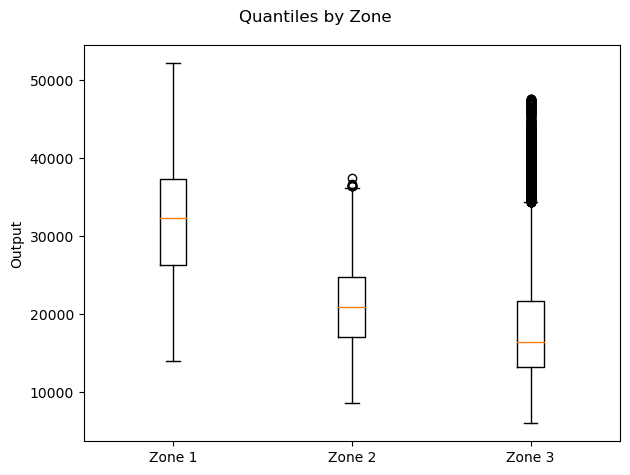

In [139]:
fig, ax = plt.subplots()

ax.boxplot(tetoun_power["zone_1_power"], positions=[1])
ax.boxplot(tetoun_power["zone_2_power"], positions=[2])
ax.boxplot(tetoun_power["zone_3_power"], positions=[3])

ax.set_xticklabels(["Zone 1", "Zone 2", "Zone 3"])
ax.set_ylabel("Output")

fig.suptitle("Quantiles by Zone")
fig.tight_layout()
plt.show()